# Loan Prediction 

### Problem Statement
"Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers."

| Variable             | Description                                   |
|----------------------|-----------------------------------------------|
| Loan_ID              | Unique Loan ID                                |
| Gender               | Male/ Female                                  |
| Married              | Applicant married (Y/N)                       |
| Dependents           | Number of dependents                          |
| Education            | Applicant Education (Graduate/ Under Graduate)|
| Self_Employed        | Self employed (Y/N)                           |
| ApplicantIncome      | Applicant income                              |
| CoapplicantIncome    | Coapplicant income                            |
| LoanAmount           | Loan amount in thousands                      |
| Loan_Amount_Term     | Term of loan in months                        |
| Credit_History       | Credit history meets guidelines               |
| Property_Area        | Urban/ Semi Urban/ Rural                      |
| **Loan_Status**        | (Target) Loan approved (Y/N)                |

`It is a Binary Classification Problem where we have to predict whether a loan would be approved or not.`

Steps - 

1. Problem Statement
2. Hypothesis Testing
3. Loading the data
4. Understanding the data
5. Exploratory Data Analysis [EDA]
    - Univariate Analysis
    - Bivariate Analysis
6. Missing value and outlier treatment
7. Evaluation Matrics for classification problems
8. Model Building: I
9. Logistic Regression with stratified k-folds cross validation
10. Feature Engineering
11. Model Building: II
    - Logistic Regression
    - Decission Tree
    - Random Forest
    - XGBoost

### Hypothesis Generation
It is the process of listing out all the possible factors that can affect the outcome.
Below are some of the factors which I think can affect the Loan Approval (dependent variable for this loan prediction problem):

- Salary: Applicants with high income should have more chances of loan approval.
- Previous history: Applicants who have repaid their previous debts should have higher chances of loan approval.
- Loan amount: Loan approval should also depend on the loan amount. If the loan amount is less, chances of loan approval should be high.
- Loan term: Loan for less time period and less amount should have higher chances of approval.
- EMI: Lesser the amount to be paid monthly to repay the loan, higher the chances of loan approval.

### Loading the DATA

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [275]:
df_train_og = pd.read_csv('Dataset/train.csv')
df_test_og = pd.read_csv('Dataset/test.csv')
df_train = df_train_og.copy()
df_test = df_test_og.copy()

In [276]:
df_train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

We have 12 independent variables(features) and 1 target variable - 'Loan_Status' in the train dataset.

In [277]:
df_test.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

We have similar features in the test dataset except the target variable 'Loan_Status'.

In [278]:
df_train.shape, df_test.shape

((614, 13), (367, 12))

We have 614 rows and 13 columns in train dataset and 367 rows and 12 columns in test dataset.

### EDA - Univariate Analysis

#### Target Variable

In [279]:
df_train['Loan_Status'].value_counts(dropna=False)

Loan_Status
Y    422
N    192
Name: count, dtype: int64

In [280]:
df_train['Loan_Status'].value_counts(normalize=True,dropna=False)

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

<Axes: xlabel='Loan_Status'>

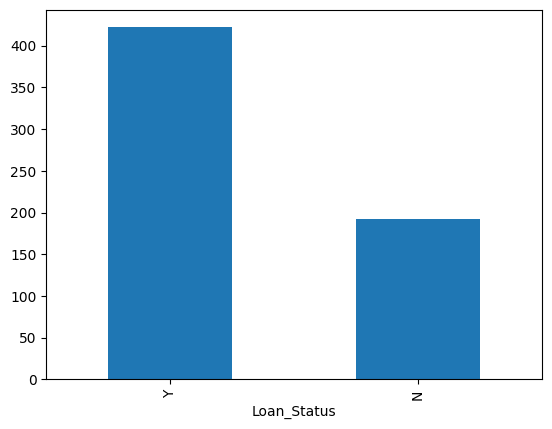

In [281]:
df_train['Loan_Status'].value_counts(dropna=False).plot.bar()

The loan of 422 (~69%) peoples out of 614 was approved.

Now lets visualize each variable separately. Different types of variables are Categorical, ordinal and numerical.

- Categorical features: These features have categories (Gender, Married, Self_Employed, Credit_History, Loan_Status)
- Ordinal features: Variables in categorical features having some order involved (Dependents, Education, Property_Area)
- Numerical features: These features have numerical values (ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term)


#### Independent Variable (Categorical)

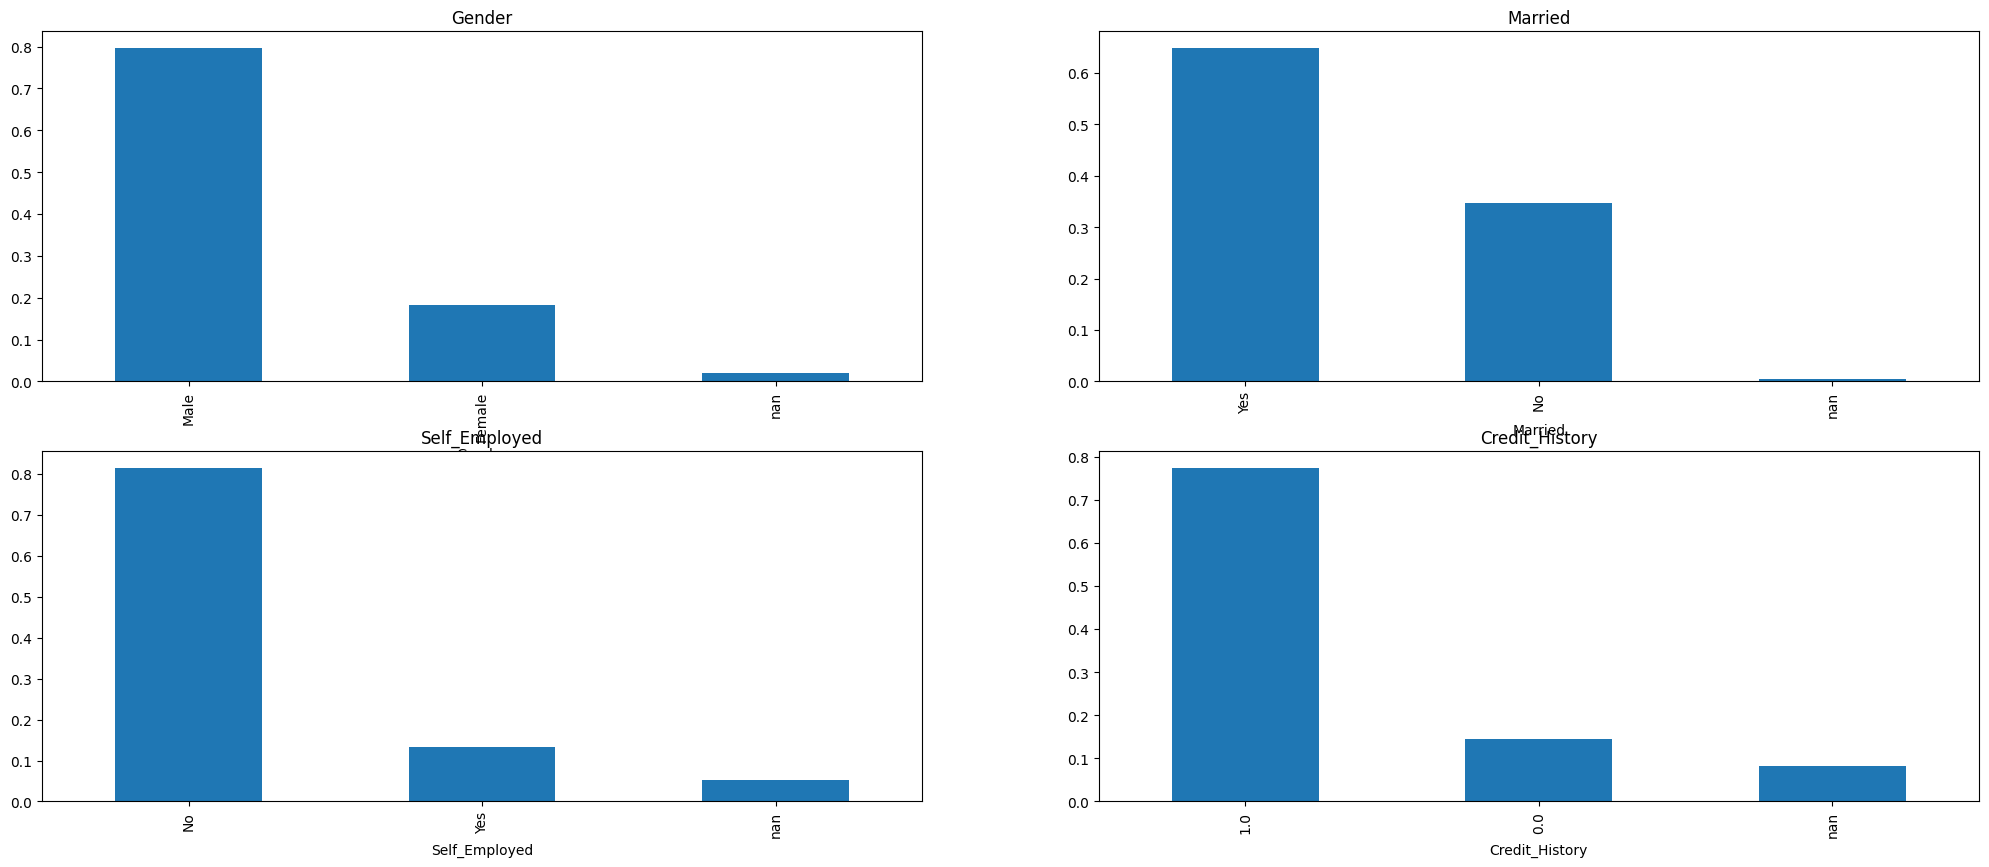

In [282]:
fig, axes = plt.subplots(2, 2, figsize=(25, 10))
df_train['Gender'].value_counts(normalize=True, dropna=False).plot.bar(figsize=(25,10), title= 'Gender', ax=axes[0,0])
df_train['Married'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Married', ax=axes[0,1])
df_train['Self_Employed'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Self_Employed', ax=axes[1,0])
df_train['Credit_History'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Credit_History', ax=axes[1,1])
plt.show()

It can be inferred from the above bar plots that:

- 80% of the applicants are male
- 65% of the applicants are married
- 15% of the applicants are self employed
- 85% of the applicants have repaid the debts

#### Independent variable (Ordinal)

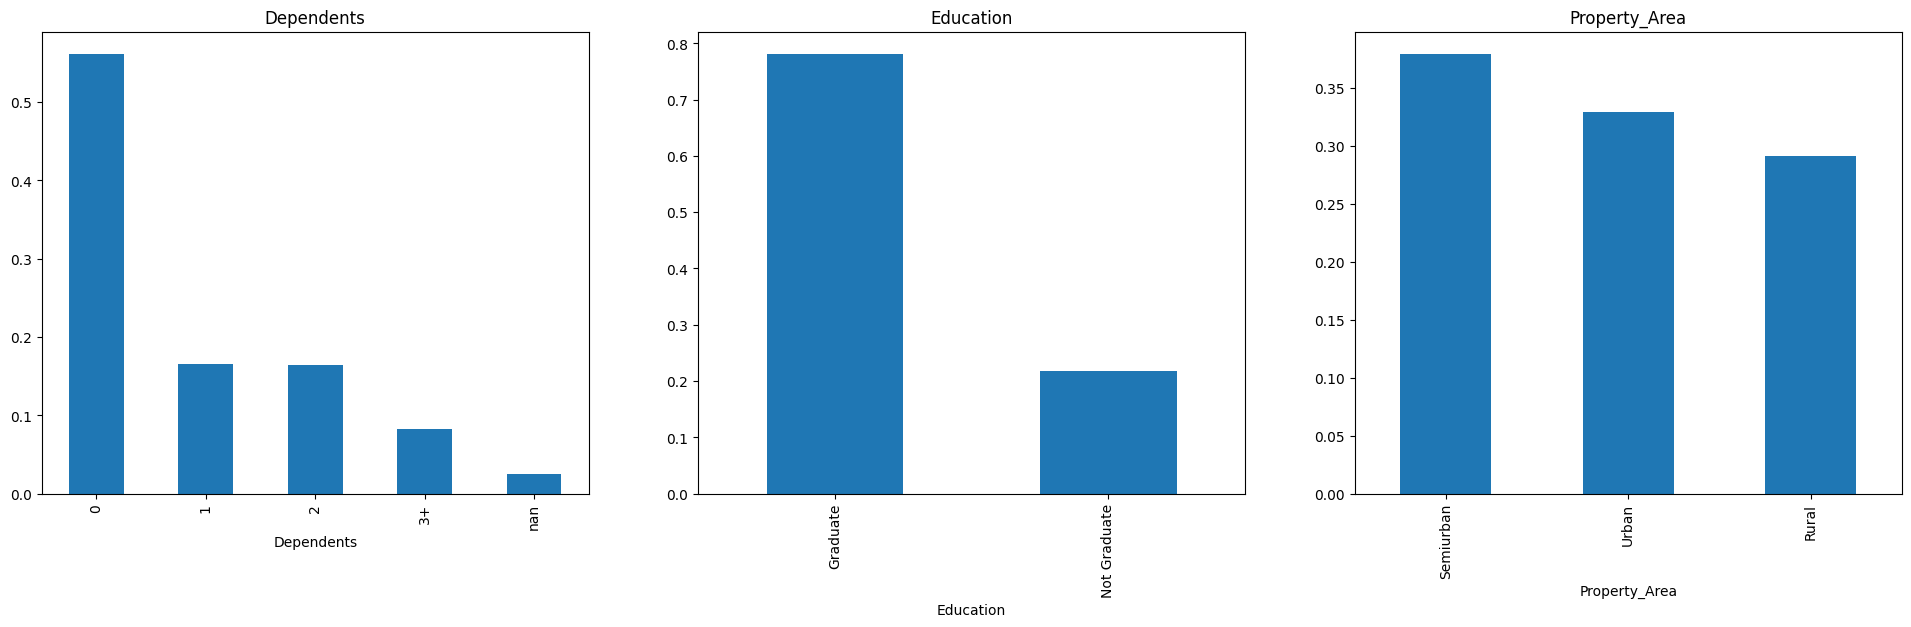

In [283]:
fig, axes = plt.subplots(1,3, figsize=(24, 6))
df_train['Dependents'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Dependents', ax=axes[0])
df_train['Education'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Education', ax=axes[1])
df_train['Property_Area'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Property_Area', ax=axes[2])
plt.show()

Following inferences can be made from the above bar charts

- Most of the applicants don't have any dependents
- ~80% of the applicants are graduate.
- Most of the applicants are from Semiurban area

#### Independent variable (Numerical)

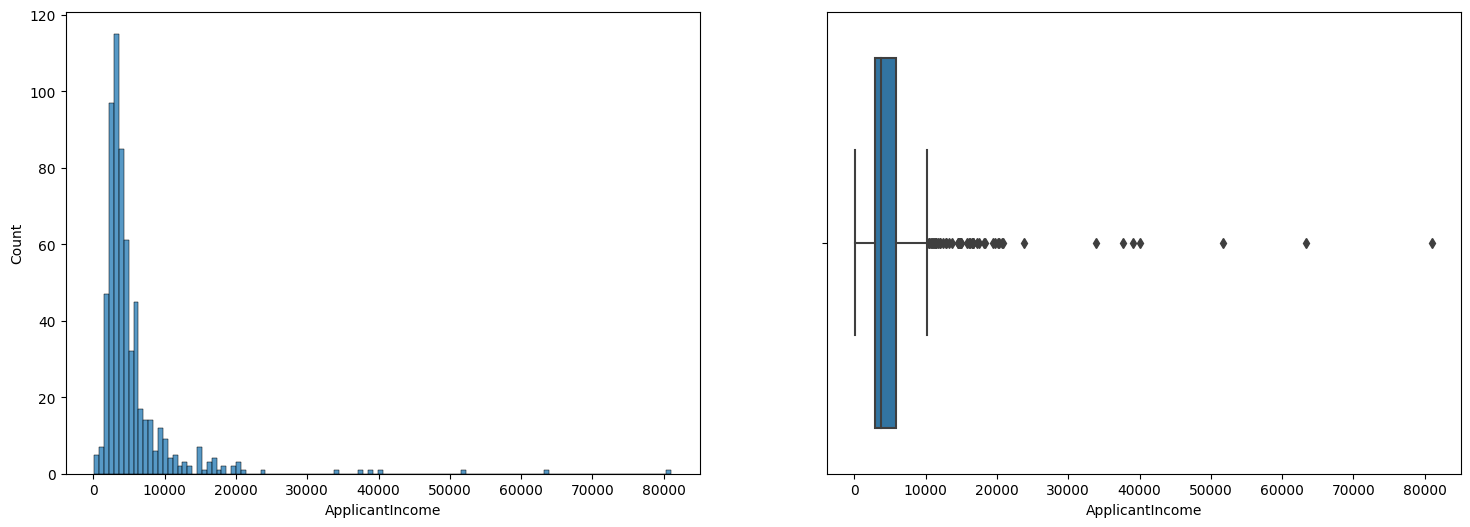

In [284]:
# Applicant Income
fig, axes = plt.subplots(1,2, figsize=(18,6))
sns.histplot(df_train['ApplicantIncome'], ax=axes[0])
sns.boxplot(df_train, x='ApplicantIncome', ax=axes[1])
plt.show()

It can be inferred that most the data in the distribution is towards left which means it is not normally distributed. We can try to make it normal later algorithm works better if the data is normally distributed.

The box plot confirms the presence of outliers/extreme values. This an be attributed to income disparity in the society. 
Part of this can be driven by the fact that we are looking at people with different education levels.

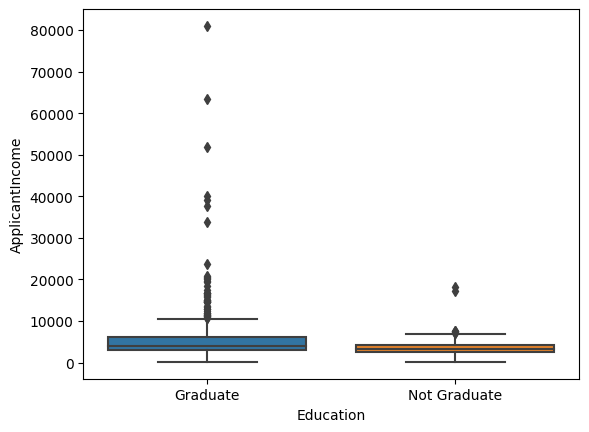

In [285]:
sns.boxplot(data=df_train, x='Education', y='ApplicantIncome')
plt.show()

We can see that there are higher number of graduates with very high incomes, which are appearing to be the outliers.

<Axes: xlabel='CoapplicantIncome'>

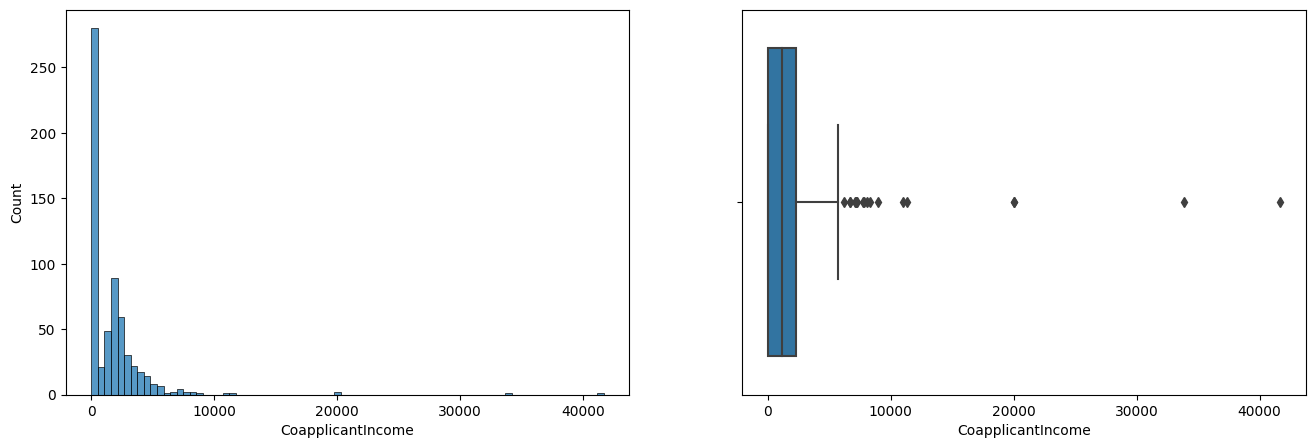

In [286]:
# Co-applicant Income
fig, axes = plt.subplots(1,2, figsize=(16, 5))
sns.histplot(df_train['CoapplicantIncome'], ax=axes[0])
sns.boxplot(data=df_train, x='CoapplicantIncome', ax=axes[1])

We see similar distribution as that of the applicant income. Majority ofn coapplicant's income ranges from 0 to 5000. We also see a lot of outliers in the co-applicant income and it is not normally distributed.

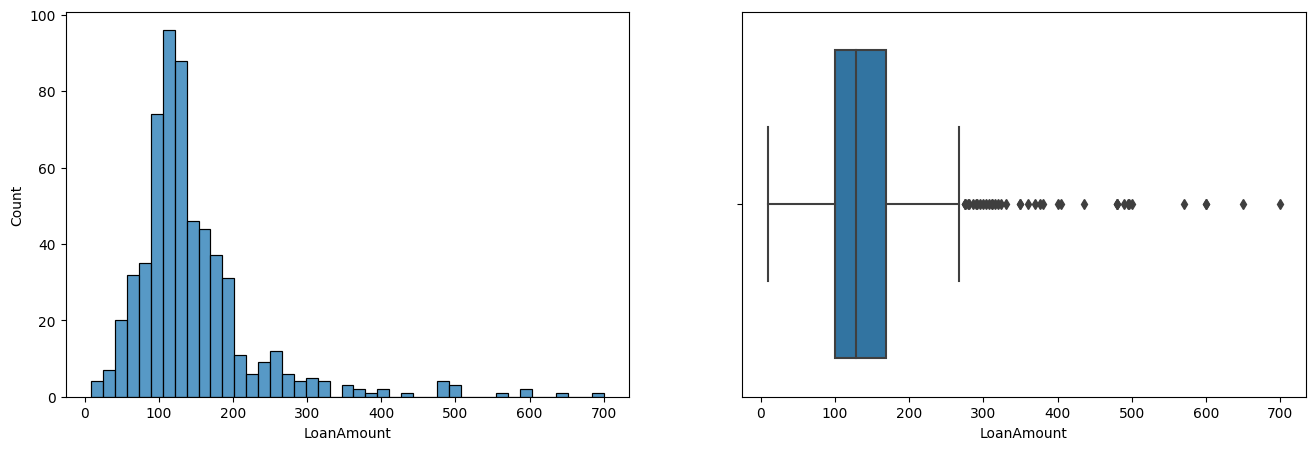

In [287]:
# Loan Amount
fig, axes = plt.subplots(1,2, figsize=(16, 5))
sns.histplot(df_train['LoanAmount'], ax=axes[0])
sns.boxplot(df_train, x='LoanAmount',ax=axes[1])
plt.show()

We see a lot of outliers in this variable and distribution is not normal

Now we would like to know how well each feature correlate with target variable (Loan Status)

### EDA - Bivariate Analysis

#### Categorical Independent Variable vs Target Variable

Text(0, 0.5, 'Proportion')

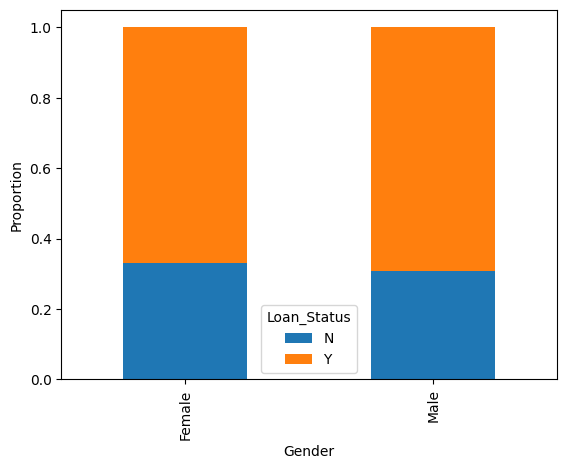

In [288]:
# Gender
Gender_tab = pd.crosstab(df_train['Gender'], df_train['Loan_Status'])
Gender_tab.div(Gender_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.ylabel('Proportion')

It can be inferred that the proportion of male and female applicants is more or less same for both approved and unapproved loans.

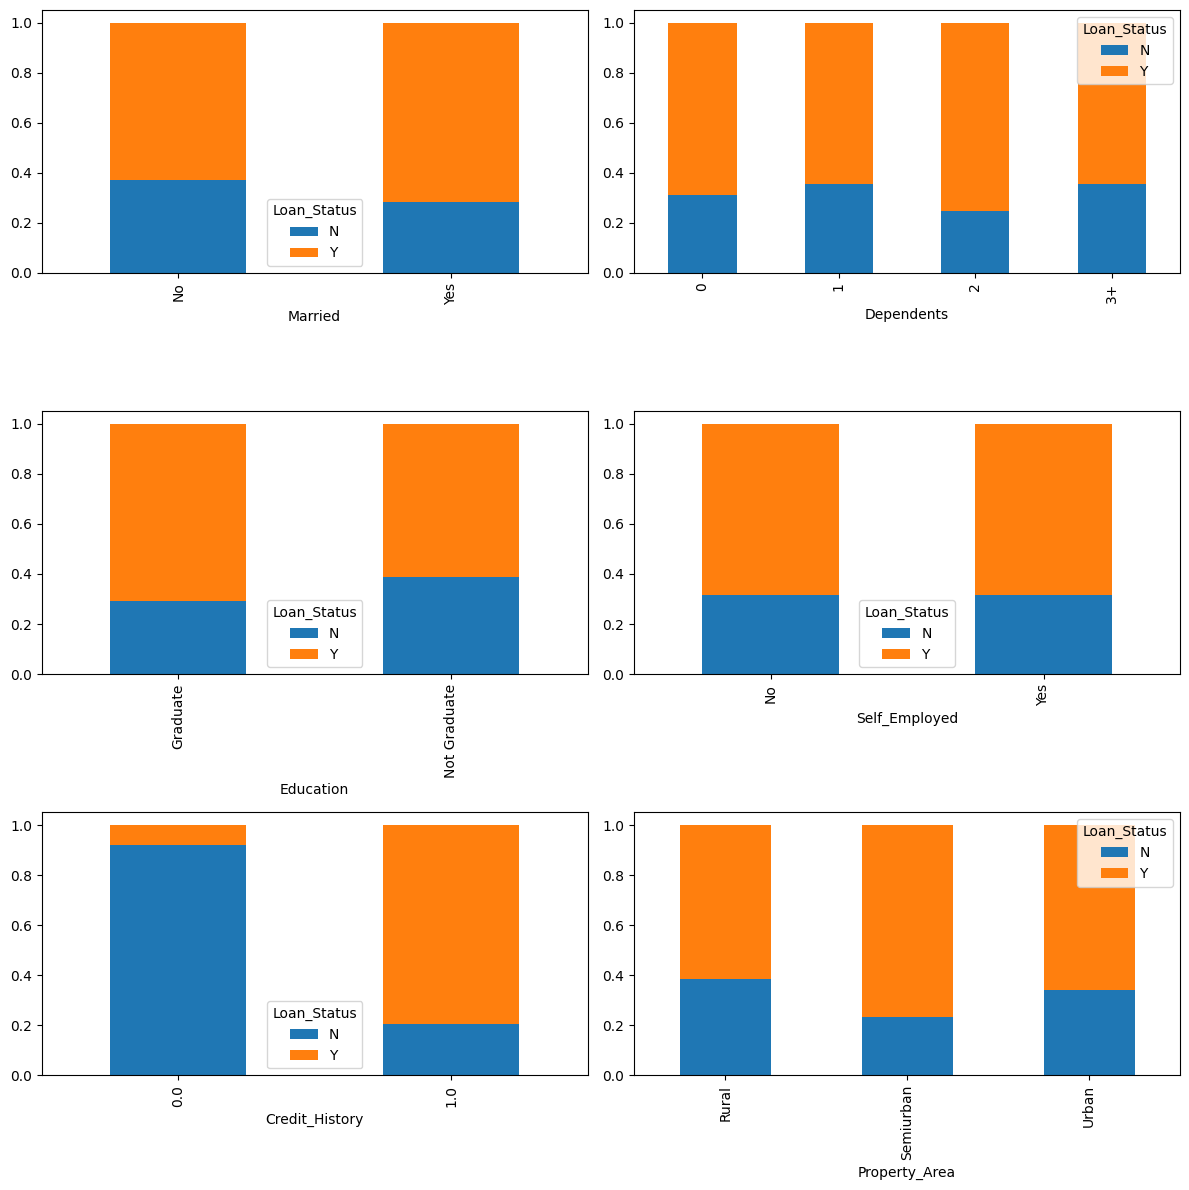

In [289]:
# Visualize the remaining categorical variables vs target variable
Married_tab = pd.crosstab(df_train['Married'], df_train['Loan_Status'])
Dependents_tab = pd.crosstab(df_train['Dependents'], df_train['Loan_Status'])
Education_tab = pd.crosstab(df_train['Education'], df_train['Loan_Status'])
Self_Employed_tab = pd.crosstab(df_train['Self_Employed'], df_train['Loan_Status'])
Credit_History_tab = pd.crosstab(df_train['Credit_History'], df_train['Loan_Status'])
Property_Area_tab = pd.crosstab(df_train['Property_Area'], df_train['Loan_Status'])

fig, axes = plt.subplots(3, 2,figsize=(12, 12))
Married_tab.div(Married_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[0, 0])
Dependents_tab.div(Dependents_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[0, 1])
Education_tab.div(Education_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[1, 0])
Self_Employed_tab.div(Self_Employed_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[1, 1])
Credit_History_tab.div(Credit_History_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[2, 0])
Property_Area_tab.div(Property_Area_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[2, 1])
plt.tight_layout()
plt.show()

- Proportion of married applicants is higher for approved loan.
- Distribution of 1 and 3+ is similar across both the categories of Loan_Status.
- graduates have higher chances of getting their loans approved.
- There is nothing significant we can infer from Self_Employed vs Loan_Status.
- It seems applicants with credit history as 1 are more likely to get their loans approved.
- Proportion of loans getting approved for semiurban is higher as compared to urban or rural areas.   

#### Numerical Independent Variable vs Target Variable

We'll try to find out the mean income of applicants for which the loan has been approved vs the mean income of applicants for which the loan has not been approved.

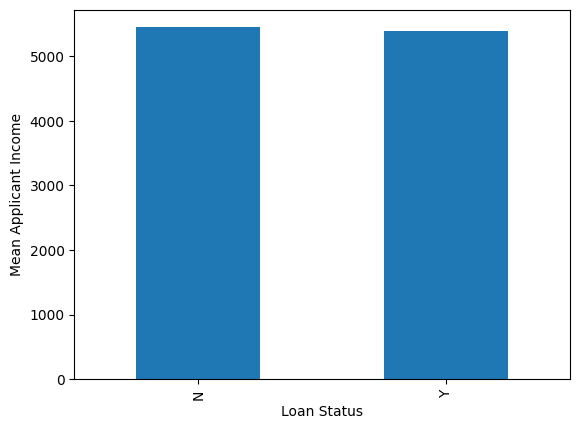

In [290]:
# Applicant Income vs Loan Status
df_train.groupby('Loan_Status')['ApplicantIncome'].mean().plot.bar()
plt.xlabel('Loan Status')
plt.ylabel('Mean Applicant Income')
plt.show()

We dont see any change in the mean applicant income. So let's make bins for the applicant income variable based on values in it and analyze the corresponding Loan status for each bin.

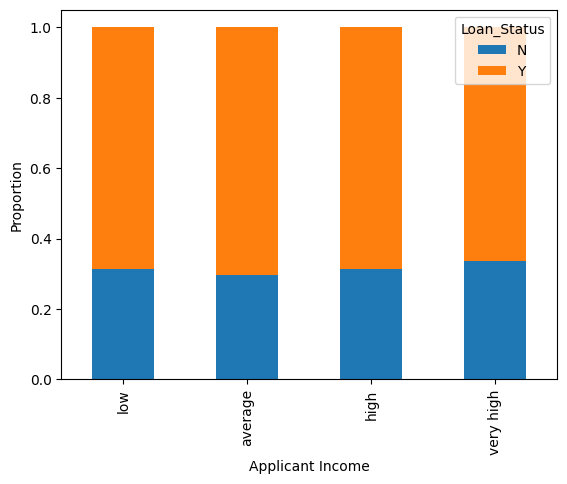

In [291]:
bins = [0, 2500, 4000, 6000, 81000]
groups = ['low','average', 'high', 'very high']
df_train['Applicant_IncomeBin'] = pd.cut(df_train['ApplicantIncome'], bins, labels=groups)

Applicant_IncomeBin_tab = pd.crosstab(df_train['Applicant_IncomeBin'], df_train['Loan_Status'])
Applicant_IncomeBin_tab.div(Applicant_IncomeBin_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.xlabel('Applicant Income')
plt.ylabel('Proportion')
plt.show()

It can be inferred that applicant income does not affect the chances of loan approval which contradicts our hypothesis in which we assumed that if the applicant's income is high the chance of loan approval will also be high.

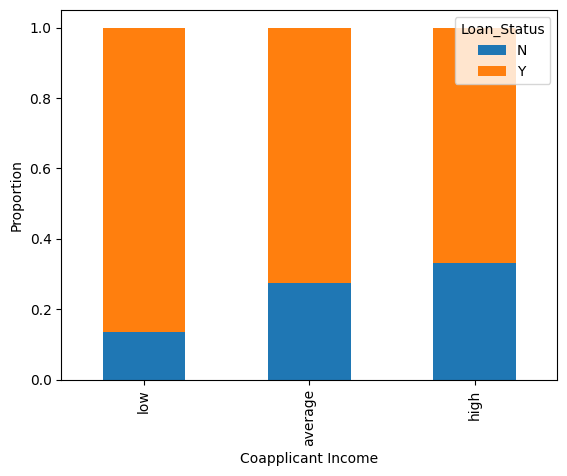

In [292]:
# Coapplicant Income vs Loan Status
bins = [0, 1000, 3000, 42000]
groups = ['low','average', 'high']
df_train['Coapplicant_IncomeBin'] = pd.cut(df_train['CoapplicantIncome'], bins, labels=groups)

Coapplicant_IncomeBin_tab = pd.crosstab(df_train['Coapplicant_IncomeBin'], df_train['Loan_Status'])
Coapplicant_IncomeBin_tab.div(Coapplicant_IncomeBin_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.xlabel('Coapplicant Income')
plt.ylabel('Proportion')
plt.show()

It shows that the applicant with co-applicant's income low has high chance of loan approval. But this does not look right. May be its because most of the applicants dont have co-applicant, so the co-applicant income for such applicant is 0 and hence the loan approval does not depend on it. We can make a new variable in which combined income of applicant and co-applicant can be stored and visualize its effect on loan status.

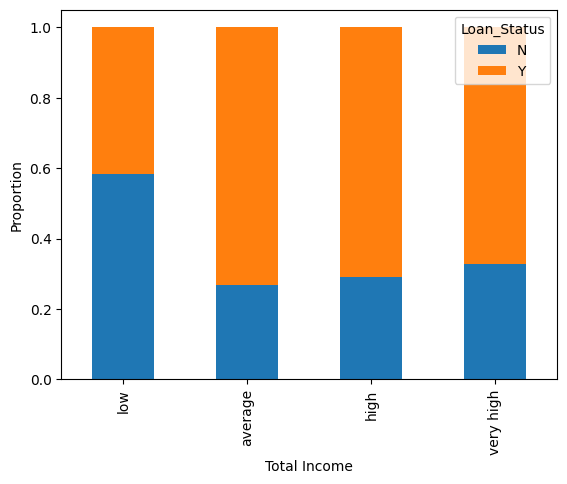

In [293]:
# Combine applicant income and co-applicant income
df_train['TotalIncome'] = df_train['ApplicantIncome']+df_train['CoapplicantIncome']

bins = [0, 2500, 4000, 6000, 81000]
groups = ['low','average', 'high', 'very high']
df_train['TotalIncome_Bin'] = pd.cut(df_train['TotalIncome'], bins, labels=groups)

TotalIncome_tab = pd.crosstab(df_train['TotalIncome_Bin'], df_train['Loan_Status'])
TotalIncome_tab.div(TotalIncome_tab.sum(1).astype(float),axis=0).plot(kind='bar', stacked=True)
plt.xlabel('Total Income')
plt.ylabel('Proportion')
plt.show()

We can see that proportion of applicants with low total income has low chance of getting loan approved than applicants with average, high or very high income.

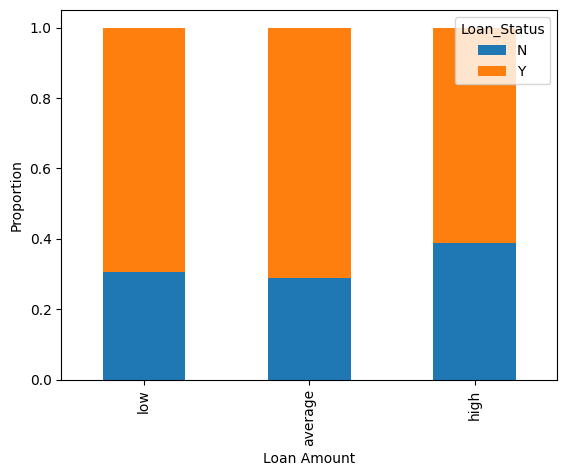

In [294]:
# Loan Amount
bins = [0, 100, 200, 700]
group = ['low','average', 'high']
df_train['LoanAmount_Bin'] = pd.cut(df_train['LoanAmount'], bins, labels=group)

LoanAmount_tab = pd.crosstab(df_train['LoanAmount_Bin'], df_train['Loan_Status'])
LoanAmount_tab.div(LoanAmount_tab.sum(1).astype(float),axis=0).plot(kind='bar', stacked=True)
plt.xlabel('Loan Amount')
plt.ylabel('Proportion')
plt.show()

It can be seen that the proportion of approved loans is higher for Low and Average Loan Amount as compared to that of High Loan Amount which supports our hypothesis in which we considered that the chances of loan approval will be high when the loan amount is less.

Let's drop the bins which we created for the exploration part. We will change the 3+ in dependents variable to 3 to make it a numerical variable.We will also convert the target variable's categories into 0 and 1 so that we can find its correlation with numerical variables. One more reason to do so is few models like logistic regression takes only numeric values as input. We will replace N with O and Y with 1.

In [295]:
df_train = df_train.drop(columns=['Applicant_IncomeBin', 'Coapplicant_IncomeBin', 'LoanAmount_Bin', 'TotalIncome_Bin', 'TotalIncome'], axis=1)
df_train['Dependents'].replace('3+', 3, inplace=True) 
df_test['Dependents'].replace('3+', 3, inplace=True)
df_train ['Loan_Status'].replace('N', 0, inplace=True)
df_train['Loan_Status'].replace('Y', 1, inplace=True)

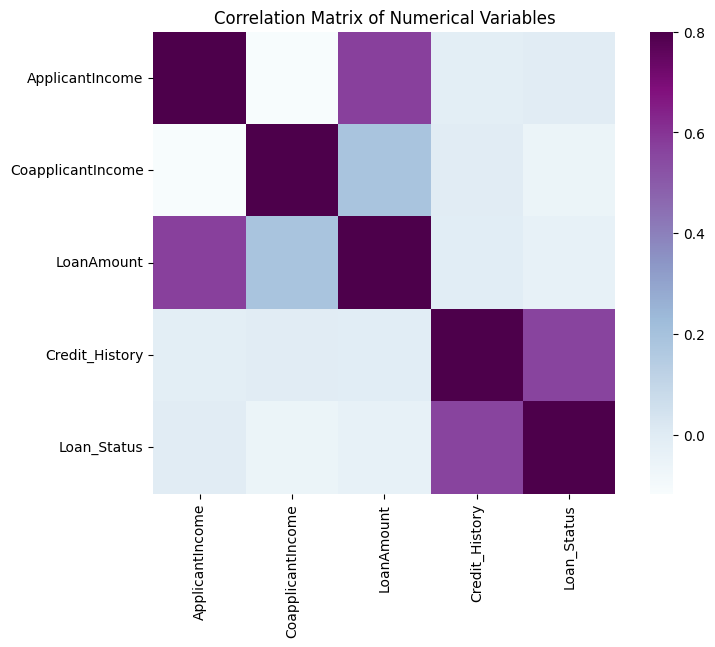

In [296]:
# Check the correlation between all the numerical variables.
matrix = df_train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History', 'Loan_Status']].corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax = .8, square = True, cmap='BuPu')
plt.title('Correlation Matrix of Numerical Variables')

plt.show()

We see that most correlated variables are:
- ApplicantIncome - LoanAmount
- Credit_History - Loan_Status

LoanAmount is also correlated with CoapplicantIncome

### Missing Value Imputaion

In [297]:
df_train.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

There are missing values in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'].
We can these methods to fill missing values.
- For numerical column: imputaion using mean or median.
- For categorical column: imputaion using mode.

In [298]:
# There are less missing values in Gender, Married, Dependents, Self_Employed and Credit_History features so we can fill them with mode of the features.
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    df_train[col].fillna(df_train[col].mode()[0], inplace=True)

In [299]:
df_train['Loan_Amount_Term'].value_counts(dropna=False)

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
NaN       14
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

It can be seen that in the Loan_Amount_Term column, 360.0 is repeating the most. So we can fill it with mode of this variable.

In [300]:
df_train['Loan_Amount_Term'].fillna(df_train['Loan_Amount_Term'].mode()[0], inplace=True)

Next, LoanAmount variable is a continuous numerical variable so we can impute missing values with mean or median. As LoanAmount variable has outliers so we will use median as mean is affected by outliers.

In [301]:
df_train['LoanAmount'].fillna(df_train['LoanAmount'].median(), inplace=True)

In [302]:
df_train.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

All the missing values are treated for train dataset. We can apply similar approach for test dataset.

In [303]:
df_test.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [304]:
for col in ['Gender', 'Dependents', 'Self_Employed', 'Credit_History']:
    df_test[col].fillna(df_test[col].mode()[0], inplace=True)

df_test['Loan_Amount_Term'].fillna(df_test['Loan_Amount_Term'].mode()[0], inplace=True)
df_test['LoanAmount'].fillna(df_test['LoanAmount'].median(), inplace=True)

In [305]:
df_test.isna().sum()


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

All the missing values in the train and test dataset are imputed. Next, Outlier treatment.

### Outlier Treatment

<Axes: xlabel='LoanAmount_norm', ylabel='Count'>

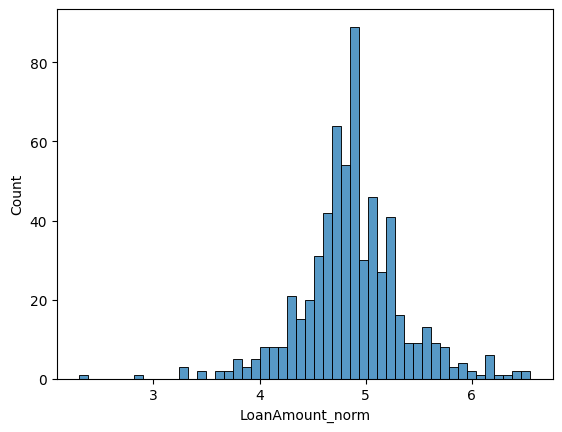

In [306]:
### Loan Amount - train data
df_train['LoanAmount_norm'] = np.log1p(df_train['LoanAmount'])
sns.histplot(df_train['LoanAmount_norm'], bins=50)

The distribution looks much closer to normal distribution. We can use Shapiro-Wilk test to check our distribution is normal or not.

In [307]:
# Perform the Shapiro-Wilk test
shapiro_test = stats.shapiro(df_train['LoanAmount_norm'])
print(f'Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')

Statistic: 0.9593752470852782, p-value: 5.47975462125035e-12


Since this p-value is extremely small (much less than a common threshold of 0.05), we can reject the null hypothesis, meaning the data is not normally distributed. But it is more towards normal than before.

In [308]:
### Loan amount - test data
df_test['LoanAmount_norm'] = np.log1p(df_test['LoanAmount'])

In [309]:
df_train.drop(columns='LoanAmount', inplace=True)
df_test.drop(columns='LoanAmount', inplace=True)

### Model Bulding: I

Drop the Loan_ID column as this is nominal data and do not have any effect on target variable.

In [310]:
df_train.drop(columns='Loan_ID', inplace=True)
df_test.drop(columns='Loan_ID', inplace=True)

In [311]:
X = df_train.drop(columns='Loan_Status')
y = df_train['Loan_Status']

In [312]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area,LoanAmount_norm
0,Male,No,0,Graduate,No,5849,0.0,360.0,1.0,Urban,4.859812
1,Male,Yes,1,Graduate,No,4583,1508.0,360.0,1.0,Rural,4.859812
2,Male,Yes,0,Graduate,Yes,3000,0.0,360.0,1.0,Urban,4.204693
3,Male,Yes,0,Not Graduate,No,2583,2358.0,360.0,1.0,Urban,4.795791
4,Male,No,0,Graduate,No,6000,0.0,360.0,1.0,Urban,4.955827


In [313]:
# dependent col is still object though
X = pd.get_dummies(X, drop_first=True)
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [314]:
X.head()

,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,LoanAmount_norm,Gender_Male,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,360.0,1.0,4.859812,True,False,True,False,False,False,False,False,True
1,4583,1508.0,360.0,1.0,4.859812,True,True,False,True,False,False,False,False,False
2,3000,0.0,360.0,1.0,4.204693,True,True,True,False,False,False,True,False,True
3,2583,2358.0,360.0,1.0,4.795791,True,True,True,False,False,True,False,False,True
4,6000,0.0,360.0,1.0,4.955827,True,False,True,False,False,False,False,False,True


In [315]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.3, random_state=0)

In [316]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [317]:
pred_cv = model.predict(X_cv)

In [318]:
from sklearn import metrics
print(metrics.classification_report(y_cv, pred_cv))

              precision    recall  f1-score   support

           0       0.92      0.43      0.59        51
           1       0.82      0.99      0.89       134

    accuracy                           0.83       185
   macro avg       0.87      0.71      0.74       185
weighted avg       0.85      0.83      0.81       185



Our predictions are 83% accurate, i.e we have identified 83% of loan status correctly